Approach 
=========
1) Each user will have a dedicated collection in milvus
2) Each time a file is ingested it is divided into 4  sentences (after preprocessing) and stored as text + vector using towhee bert pipeline
3) When user asks a question similarity search is made in the vector DB and context is retrieved
4) Context + question to hugging face pipeline("question-answering") gives us the expected answer

Step1 : Ingestion of files

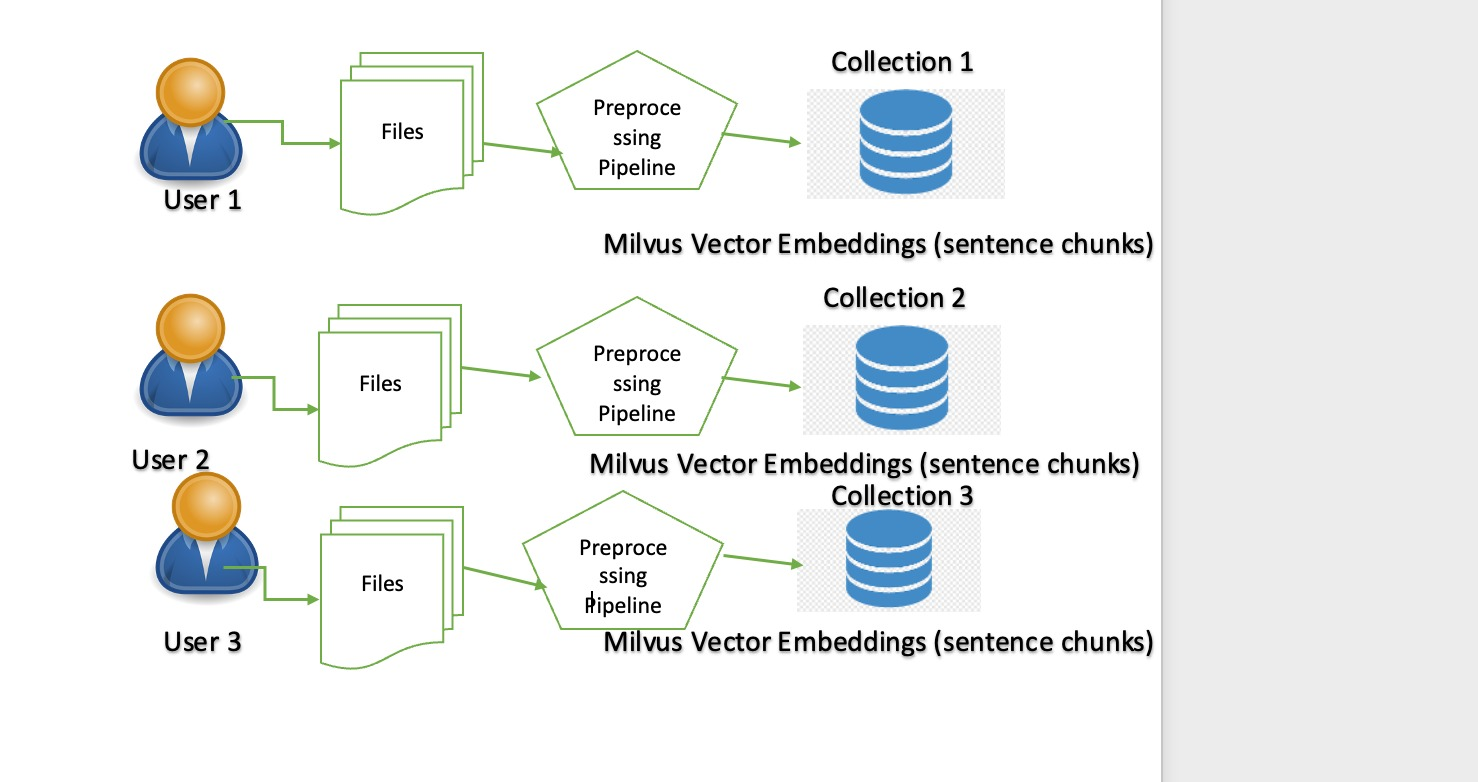

Step 2: Questions sent by user

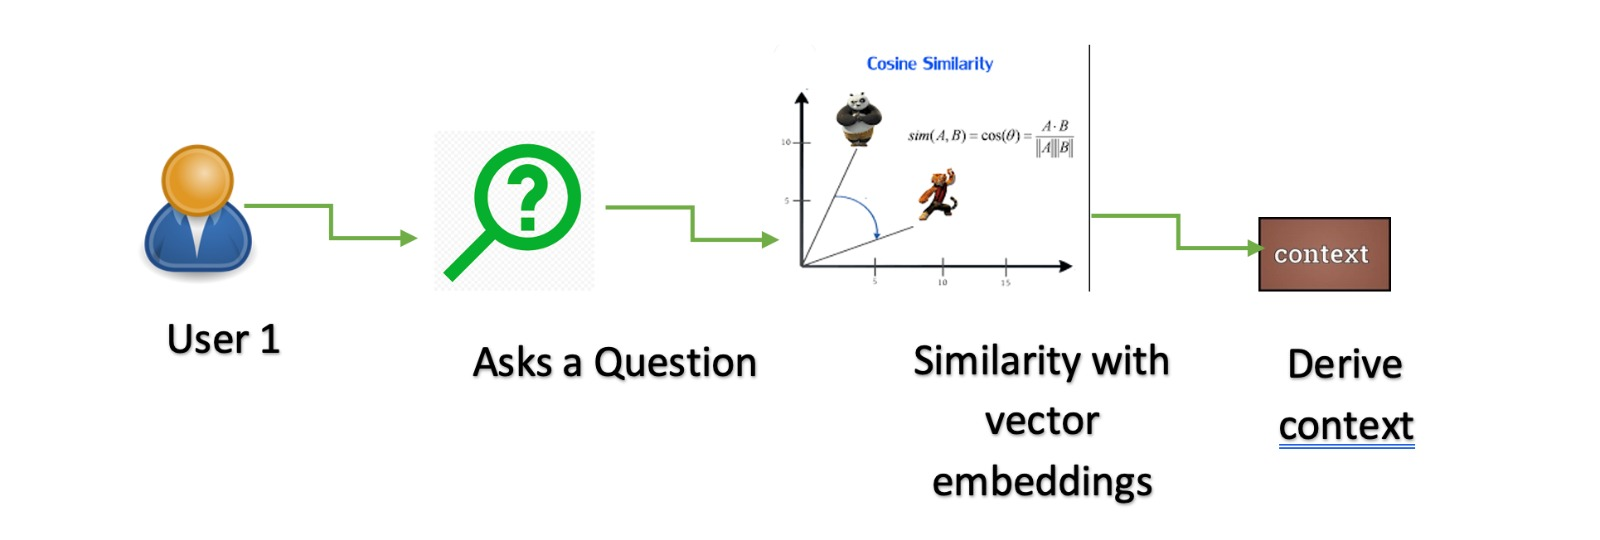

Step 3: Information retrieval

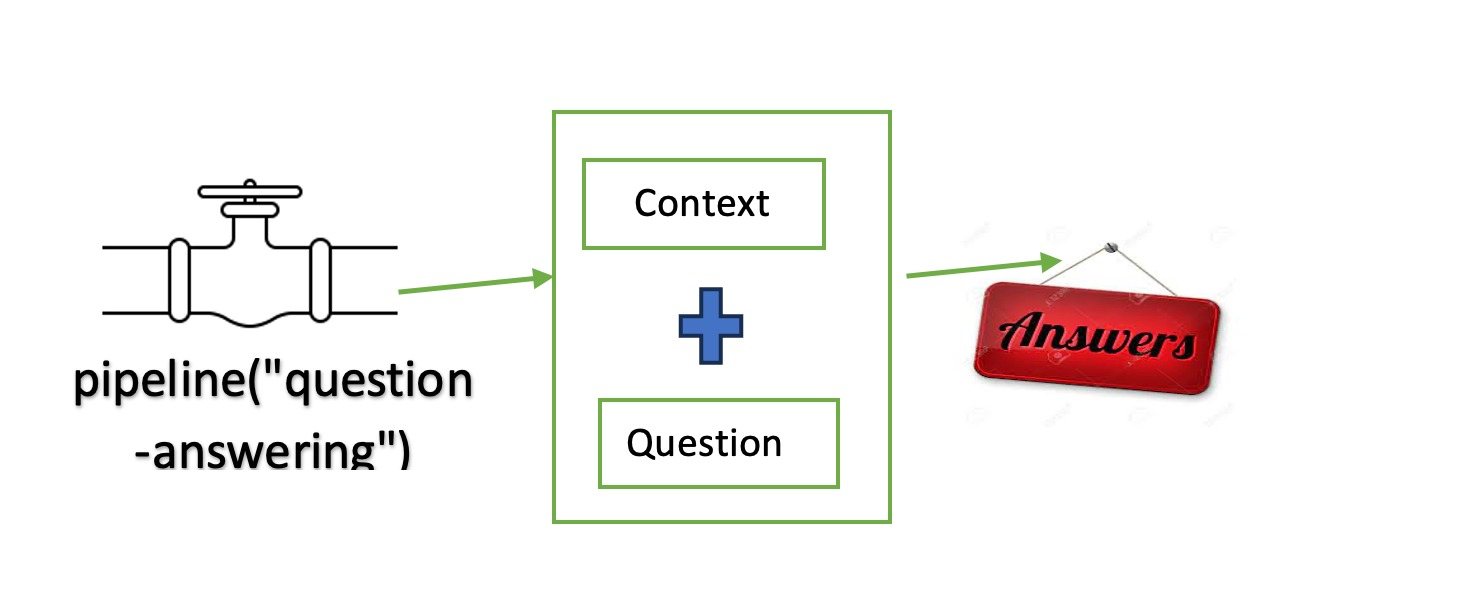

Needed imports and requirements

In [ ]:
!pip3 install -q towhee==1.0.0rc1 pymilvus dill --user
!pip3 install nltk
!pip3 install sentence-transformers

In [ ]:
import pandas as pd
import towhee
from nltk.tokenize import sent_tokenize

In [ ]:


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility
from towhee.dc2 import pipe, ops, DataCollection

In [ ]:
from milvus import default_server
from pymilvus import connections, utility
from sentence_transformers import SentenceTransformer


In [ ]:

import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

In [ ]:
from transformers import pipeline


In [ ]:
transformer = SentenceTransformer('all-MiniLM-L6-v2')


Connection Params to the RND Milvus DB

In [ ]:
COLLECTION_NAME=" "
HOST=" "
PORT=" "
DIMENSION = 384  # Embeddings size
BATCH_SIZE = 128
TOPK = 1

In [ ]:
connections.connect(host=HOST, port=PORT)

connections

In [ ]:
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
if utility.has_collection(COLLECTION_NAME):
    print('COLLECTION_NAME exists and we are going to drop')
    utility.drop_collection(COLLECTION_NAME)
else:
    print('COLLECTION_NAME does not exists')

Schema is ID, text(sentence chunks) and the corresponding vector embedding. BERT has only encoder option henceforth able to get context when stored as chunks

In [ ]:
# object should be inserted in the format of (title, date, location, speech embedding)


# Create collection which includes the id, title, and embedding.
fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='text', dtype=DataType.VARCHAR, max_length=200),  # VARCHARS need a maximum length, so for this example they are set to 200 characters
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
]
schema = CollectionSchema(fields=fields, description='  corpus')
collection = Collection(name=COLLECTION_NAME, schema=schema)



In [ ]:
# Create an IVF_FLAT index for collection.
index_params = {
    'metric_type':'L2',
    'index_type':"IVF_FLAT",
    'params':{'nlist': 1536}
}
collection.create_index(field_name="embedding", index_params=index_params)
collection.load()

In [ ]:
bert_op = towhee.ops.text_embedding.transformers(model_name='bert-base-uncased').get_op()

In [ ]:
column_names=["text", "embedding"]
data = []
df=pd.DataFrame(data, columns=column_names)

In [ ]:
def readfile(filename):
    #open text file in read mode
    text_file = open(filename, "r")
    
    #read whole file to a string
    data = text_file.read()
    sentences = sent_tokenize(data)
    for i in range(0, len(sentences), 4):
        txt = sentences[i]
        for j in range(1,3):
            if (len(sentences) > i+j):
               txt +=  sentences[j+i] 
        txt = txt.replace('\n',' ').lower()
        # print(embedding.shape)
        embeds = transformer.encode(txt) 
        df.loc[len(df.index)] = [txt, embeds] 
        txt=""
    #close file
    text_file.close()
    return 


sentence chunks are lowercased/preprocessed group of four sentences from which vector embeddings are generated using the towhee pipeline(towhee.ops.text_embedding.transformers)

In [ ]:
# sample Legal files
readfile("document.txt")
df.head()


In [ ]:
df.shape

In [ ]:
from towhee import ops, pipe, DataCollection


insert_pipe =  (pipe.input('df')
            .flat_map('df', 'data', lambda df: df.values.tolist())
            .map('data', 'res', ops.ann_insert.milvus_client(host=HOST, 
                                                            port=PORT,
                                                            collection_name=COLLECTION_NAME))
             .output('res')
)

In [ ]:
insert_pipe(df)

In [ ]:
collection.load()
collection.num_entities

In [ ]:
question=[]

In [ ]:
questionset2=[]

In [ ]:
context=[]

In [ ]:
# Search for titles that closest match these phrases.
import time

search_terms = questionset2

# Search the database based on input text
def embed_search(data):
    embeds = transformer.encode(data) 
    return [x for x in embeds]

search_data = embed_search(search_terms)

start = time.time()
res = collection.search(
    data=search_data,  # Embeded search value
    anns_field="embedding",  # Search across embeddings
    param={},
    limit = TOPK,  # Limit to top_k results per search
    output_fields=['id','text']  # Include title field in result
)
end = time.time()

for hits_i, hits in enumerate(res):
    print('text:', search_terms[hits_i])
    print('Search Time:', end-start)
    print('Results:')
    for hit in hits:
        context.append(hit.entity.get('text'))
        # if (question1.lower() == search_terms[hits_i]):
        #     hitIdsOfQuestion1.append(hit.entity.get('id'))
        #     context1 += hit.entity.get('text')
        # elif (question2.lower() == search_terms[hits_i]):
        #     hitIdsOfQuestion2.append(hit.entity.get('id'))
        #     context2 += hit.entity.get('text')
        # elif (question3.lower() == search_terms[hits_i]):
        #     hitIdsOfQuestion3.append(hit.entity.get('id'))
        #     context3 += hit.entity.get('text')
        # elif (question4.lower() == search_terms[hits_i]):
        #     hitIdsOfQuestion4.append(hit.entity.get('id'))
        #     context4 += hit.entity.get('text')
        print( hit.entity.get('text'), '----', hit.distance)
    print()

In [ ]:
question_answerer = pipeline("question-answering")

for i in  range(28):
    question_answerer(question=question[i], context=context[i])

In [ ]:
question_answerer = pipeline("question-answering")

In [ ]:
question_answerer(question=questionset2[7], context=context[7])

In [ ]:
questionset2.append("Contract Id")
questionset2.append("current status of the contract") #'answer': 'effective date of 06/88/2016'
questionset2.append("Start date of the contract") #'answer': 'february 1%, 2023'
questionset2.append("thereafter End date of the contract") # 'answer': 'january 31%, 2024'
questionset2.append("Contract shall continue for how much term")#'answer': 'twelve (12) months'}
questionset2.append("Upon expiration of the Initial Term how it renews")#'answer': 'automatically renew for successive twelve (12) months'}
questionset2.append("notice period in days  prior written notice of termination")#'answer': 'nless than ninety (90) days'}
questionset2.append("renewal duration notice of termination effective on the next scheduled")# 'answer': 'either party provides the other party with nless than ninety (90) days'}
questionset2.append("how contract will terminate upon any termination")#'answer': 'automatically terminate upon any termination or expiration of the agreement'}
questionset2.append("how many days is Contract notice of termination ")# 'answer': 'ninety (90) days'}